# Свёртка в обработке изображений и в нейронных сетях

In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import skimage
from skimage.transform import resize
%matplotlib inline
_ = torch.manual_seed(1)

### 1. Операция свёртки
Общий вид свёртки:
$ g(x,y) = \omega*f(x,y) = \sum_{dx=-a}^{a} \sum_{dy=-b}^{b} \omega(dx,dy)f(x+dx, y+dy)$,

где $g(x,y)$ - это результат свёртки (отфильтрованное изображение), $f(x,y)$ - оригинальное изображение, $\omega$ - ядро фильтра.\
Каждый элемент ядра фильтра расположен в пределах $-a\leq dx\leq a$ и $-b\leq dy\leq b$.

В глубоком обучении используется не сама свёртка, где ядро повёрнуто на 180$^{\circ}$, а кросс-корреляция. На это явно указывет, например, [документация PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html). Но мы всё равно будем пользоваться термином "свёртка".

#### Визуализация свёртки
![Convolution_example](media/conv_ex.png "Convolution example")
[код](https://tex.stackexchange.com/questions/522118/visualizing-matrix-convolution)

#### Зачем нам свёртки в нейронных сетях?
Если мы работаем с изображениями, то на вход подаём тензор с большим количеством элементов. Например, для классической полносвязной сети и серого изображения $32\times32$ у сети будет вектор из 1024 элементов на входе. Если в сети всего 1 полносвязный слой из 10 нейронов (не будет учитывать выход сети), то в сети будет уже 10241 вес и соответствующее количество операций сложения и умножения. Свёртки используются для уменьшения размерности, т. к. при прохождении ядра по изображению используются разделяемые веса.\
Для задачи классификации факт наличия признака важнее знания места его точного положения.

### 2. Классические примеры свёрток

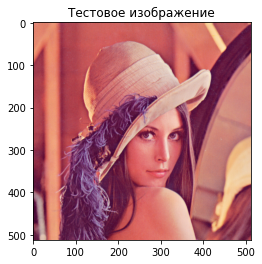

In [14]:
# Загружаем тестовое изображение
plt.title('Тестовое изображение')
lena = plt.imread('media/Lenna.png')
plt.imshow(lena)

(128, 128)


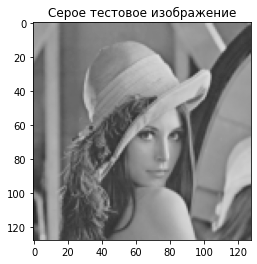

In [3]:
# Делаем изображение серым
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [1/3, 1/3, 1/3])
 
gray = rgb2gray(lena)
gray = resize(gray, (128, 128))
print(gray.shape)
plt.title('Серое тестовое изображение')
plt.imshow(gray, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)

In [4]:
# Ядра фильтров
kernels = {
    'sobel_y': [[1, 2, 1],
                [0, 0, 0],
                [-1, -2, -1]],
    'sobel_x': [[-1, 0, 1],
                [-2, 0, 2],
                [-1, -0, 1]],
    'gaussian_blur': np.array([[1, 4, 6, 4, 1],
                               [4, 16, 24, 16, 4],
                               [6, 24, 36, 24, 6],
                               [4, 16, 24, 16, 4],
                               [1, 4,  6,  4, 1]]) / 256,
    'box_filter': np.array([[1, 1, 1, 1, 1],
                            [1, 1, 1, 1, 1],
                            [1, 1, 1, 1, 1],
                            [1, 1, 1, 1, 1],
                            [1, 1, 1, 1, 1]]) / 25,
}

(1, 1, 126, 126)


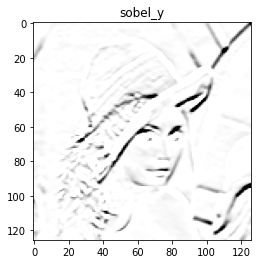

(1, 1, 126, 126)


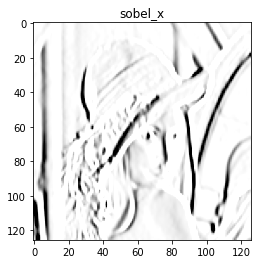

(1, 1, 124, 124)


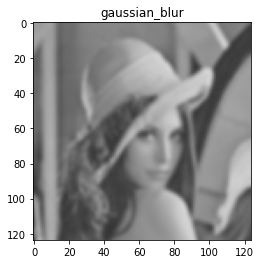

(1, 1, 124, 124)


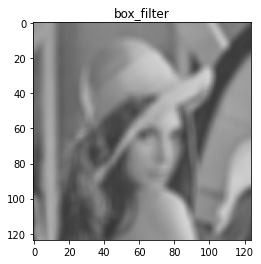

In [5]:
# Добавляем 1 канал для места с батче и 1 цветовой канал
x = torch.from_numpy(gray).unsqueeze(0).unsqueeze(0)
# БАТЧ, КАНАЛЫ, ШИРИНА, ВЫСОТА
# Применяем фильтры
for name, kernel in kernels.items():
    filtered = F.conv2d(x, torch.tensor(kernels[name], dtype=torch.float64).expand(1, 1, len(kernels[name]), len(kernels[name][0])), stride=1, padding=0)
    plt.title(name) 
    result = filtered.numpy()
    side_size = result.shape[-1]
    print(result.shape)
    cmap = 'Greys' if 'sobel' in name else 'gray'
    plt.imshow(result.reshape((side_size,side_size)), cmap=cmap, vmin=0, vmax=1)
    plt.show()

#### Простейший алгоритм поиска граней (оператор Собеля)
1. Считаем вертикальные и горизонтальные градиенты $G_y$ и $G_x$
2. Находим приближённое значение величины градиента $G = \sqrt{G_x^2+G_y^2}$

torch.Size([1, 1, 126, 126])


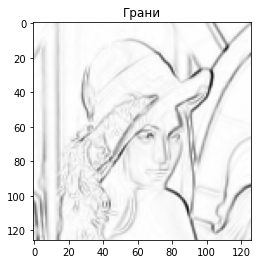

In [6]:
sobel_x = torch.tensor(kernels['sobel_x'], dtype=torch.float64).expand(1, 1, 3, 3)
sobel_y = torch.tensor(kernels['sobel_y'], dtype=torch.float64).expand(1, 1, 3, 3)
filtered_x = F.conv2d(x, sobel_x, stride=1, padding=0)
filtered_y = F.conv2d(x, sobel_y, stride=1, padding=0)
gradient_magnitude = torch.sqrt(torch.square(filtered_x) + torch.square(filtered_y))

side_size = gradient_magnitude.shape[-1]
print(gradient_magnitude.shape)
plt.title("Грани")
plt.imshow(gradient_magnitude.reshape((side_size,side_size)), cmap='Greys', vmin=0, vmax=gradient_magnitude.max())
plt.show()

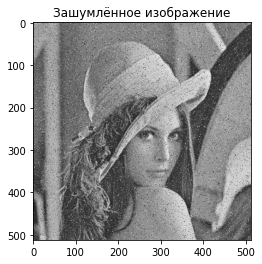

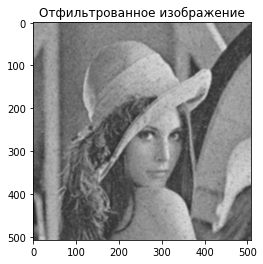

In [7]:
# Пример борьбы с шумом типа "соль и перец"
gray_large = rgb2gray(lena)
noisy = skimage.util.random_noise(gray_large, mode='s&p', amount=0.05)
plt.title('Зашумлённое изображение')
plt.imshow(noisy, cmap='gray')
plt.show()
img = torch.tensor(noisy, dtype=torch.float64).expand(1, 1, noisy.shape[-2], noisy.shape[-1])
w = torch.tensor(kernels['box_filter'], dtype=torch.float64).expand(1, 1, 5, 5)
filtered = F.conv2d(img, w, stride=1, padding=0)
side_size = filtered.shape[-1]
plt.title("Отфильтрованное изображение")
plt.imshow(filtered.reshape((side_size,side_size)), cmap='gray', vmin=0, vmax=1)
plt.show()


### 3. Особенности операции свёртки
#### Обработка граничных условий (padding)
Результирующее изображение после свёртки имеет меньшее разрешение, чем исходное изображение. Часто в нейронных сетях мы хотим сохранить разрешение, для чего используется расширение исходного изображения до размера\
$(n_h−k_h+p_h+1)×(n_w−k_w+p_w+1)$,\
где $n_h$ и $n_w$ - высота и ширина исходного изображения,\
$k_h$ и $k_w$ - высота и ширина ядра фильтра (фильтр может быть анизотропным),\
$p_h$ и $p_w$ - количество добавляемых строк и столбцов. Обычно $p_h=k_h−1$ и $p_w=k_w-1$ 
В свёрточных сетях обработка граничных условий дополнением дополнительных строк и столбцов обычно происходит нулями, но может быть и другим.

В примере снизу обработка граничных условий осуществлена добавлением строк и столбцов на значение больше, чем $p_h=k_h−1$ и $p_w=k_w-1$
![Padding](media/padding.svg "Padding")


#### Шаг применения свёртки (stride)
Иногда мы хотим сдвигать окно свёртки больше, чем на 1 позицию, что приведёт к уменьшению выходного разрешения:
$⌊(n_h−k_h+p_h+s_h)/s_h⌋×⌊(n_w−k_w+p_w+s_w)/s_w⌋$,\
где $s_h$ и $s_w$ - вертикальный и горизонтальный шаг свёртки.

В примере внизу вертикальный шаг 3, а горизонтальный - 2.\
Размер изображения $(3-2+2+3)/3 \times (3-2+2+2)/2  =  2 \times int(2.5)$
![Stride](media/conv-stride.svg "Stride")


torch.Size([1, 1, 3, 3])


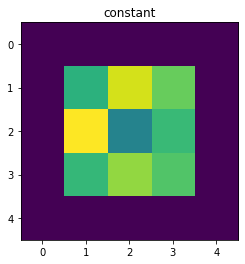

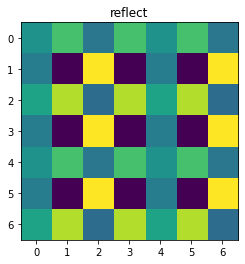

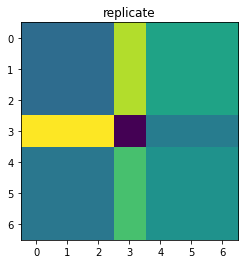

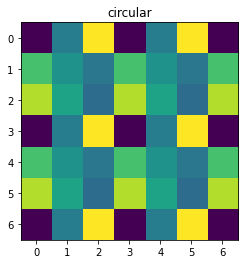

In [15]:
# Пример обработки граничных условий
size = 3
modes = ['constant', 'reflect', 'replicate', 'circular']
image = torch.rand(1, 1, size, size)
print(image.shape)
for mode in modes:
    if mode == 'constant':
        padded = torch.nn.functional.pad(image, (1,1,1,1), mode=mode, value=0.0)
    elif mode == 'reflect':
        padded = torch.nn.functional.pad(image, pad=(2,2,2, 2), mode=mode)
    elif mode == 'replicate':
        padded = torch.nn.functional.pad(image, pad=(2,2, 2, 2), mode=mode)
    elif mode == 'circular':
        padded = torch.nn.functional.pad(image, pad=(2,2, 2, 2), mode=mode)
    plt.title(mode)
    plt.imshow(padded[0,0,:,:].numpy())
    plt.show()

#### Разреженность свёртки (dilation)
В сетях часто используются свёртки $3\times3$, так как их можно быстро посчитать. Если объект поиска большой, а сеть неглубокая, то на последнем свёрточном слоем сети пиксель может не покрыть рецептивным полем (receptive field) значимую часть объекта. Простым решением этой проблемы будет увеличить размер ядра свёртки, но это приведёт к значительному увеличению вычислительной сложности.\
Пример:\
Свёртка $3\times3$, применённая к серому изображению имеет 9 весов (+1 от сдвига, bias). Немного бОльшая свёртка $5\times5$ имеет 25 весов или в 2,77 раз больше и значительное увеличение количества необходимых операций умножения и сложения. [код](https://github.com/sagartesla/flops-cnn/blob/master/flops_calculation.py)

In [16]:
channels = 1
num_filters = 1
input_shape = (channels,512,512) # Format:(channels, rows,cols)
conv_filters = {
    '3x3': (num_filters,channels,3,3), # Format: (num_filters, channels, rows, cols)
    '5x5': (num_filters,channels,5,5),
    '7x7': (num_filters,channels,7,7),
    '11x11': (num_filters,channels,11,11)
}
stride = 1
padding = 1
activation = 'relu'
print('Number of FLOPS required')
for name, conv_filter in conv_filters.items():
    if conv_filter[1] == 0:
        n = conv_filter[2] * conv_filter[3] # vector_length
    else:
        n = conv_filter[1] * conv_filter[2] * conv_filter[3]  # vector_length

    flops_per_instance = n + ( n -1)    # general defination for number of flops (n: multiplications and n-1: additions)
    num_instances_per_filter = (( input_shape[1] - conv_filter[2] + 2 * padding) / stride) + 1  # for rows
    num_instances_per_filter *= ((input_shape[1] - conv_filter[2] + 2 * padding) / stride) + 1  # multiplying with cols
    flops_per_filter = num_instances_per_filter * flops_per_instance
    total_flops_per_layer = flops_per_filter * conv_filter[0]  # multiply with number of filters

    if activation == 'relu':
        total_flops_per_layer += conv_filter[0] * input_shape[1] * input_shape[2]

    print(f'{name}: {total_flops_per_layer/1000000:.2f} GFLOPS')

Number of FLOPS required
3x3: 4.72 GFLOPS
5x5: 13.01 GFLOPS
7x7: 25.29 GFLOPS
11x11: 61.48 GFLOPS


Другим способом увеличения рецептивного поля является увеличение количества последовательных свёрток.
Например, 2 свёртки $3\times3$ имеют то же рецептивное поле, что одна свёртка $5\times5$. При этом, количество весов в двух последовательных свёртках $3\times3$ будет 18, а в $5\times5$ будет 25. 

| Свёртки | Веса | FLOPS |
|---------|------|-------|
| $5\times5$      | 25   | 49     |
| две $3\times3$  | 18   | 34     |
|         |      |       |

<img src="media/stack_convs.png" alt="Drawing" style="width: 200px;"/>

Разреженная свёртка (dilated, atrous) позволяет увеличить рецептивное поле без увеличения количества параметров и FLOPS.
![Dilated](media/dilated.png "Dilated")
[Изображение и идея](https://arxiv.org/abs/1511.07122v3)

| Свёртки              | Веса | FLOPS |
|---------             |------|-------|
| $5\times5$           | 25   | 49     |
| две $3\times3$       | 18   | 34     |
| $3\times3$ stride=2  | 9    | 17      |

In [10]:
# Одна операция свёртки
def single_conv(img, w, b):
    # Поэлементное произведение
    s = torch.multiply(img, w)
    # сумма произведений
    g = torch.sum(s)
    # сдвиг
    g = g + b
    return g

In [17]:
# Попробуем нашу свёртку
img_raw = [[5, 20, 100],
          [15, 30, 120],
          [10, 40, 150]] # Градиент полодительный в направлении слева направо
img = torch.tensor(img_raw, dtype=torch.float64).expand(1, 1, 3, 3)
w = torch.tensor(kernels['sobel_x'], dtype=torch.float64).expand(1, 1, 3, 3)
b = torch.tensor([0], dtype=torch.float64)

g = single_conv(img, w, b)

# Сравним с реализацией в PyTorch
filtered_x = F.conv2d(img, w, stride=1, padding=0)

print(f'Наша свёртка: {g.numpy().reshape(1)} | PyTorch: {filtered_x.numpy().reshape(1)}')

Наша свёртка: [445.] | PyTorch: [445.]


### 4. Соединение данных

Данные в сети распространяются не обязательно только от предыдущего слоя к следующему.
##### Боковые соединения суммой (skip connections)
Этот способ заключается в добавлении значений сигнала после разных операций свертки. Итоговый размер тензора равен размерам входных тензоров.

<img src="media/resnet_block.png" alt="Drawing" style="width: 300px;"/>

##### Соединение конкатенацией
Существует так же способ объединения сигналов конкатенацией, когда при объединении тензоров те не складываются, а они конкатенируются с увеличением одной из размерности.

<img src="media/inception_module.png" alt="Drawing" style="width: 400px;"/>

In [12]:
# Реализация бокового соединения в PyToch
filtered_x = F.conv2d(img, w, stride=1, padding=1)
filtered_x_skip_connection = filtered_x + img
print(img, '\n',filtered_x_skip_connection, '\n', filtered_x)
print(img.shape, '\n',filtered_x_skip_connection.shape, '\n', filtered_x.shape)

tensor([[[[  5.,  20., 100.],
          [ 15.,  30., 120.],
          [ 10.,  40., 150.]]]], dtype=torch.float64) 
 tensor([[[[ 75., 315.,  30.],
          [135., 475.,   0.],
          [120., 425.,  40.]]]], dtype=torch.float64) 
 tensor([[[[  70.,  295.,  -70.],
          [ 120.,  445., -120.],
          [ 110.,  385., -110.]]]], dtype=torch.float64)
torch.Size([1, 1, 3, 3]) 
 torch.Size([1, 1, 3, 3]) 
 torch.Size([1, 1, 3, 3])


In [13]:
# Реализация соединения конкатенацией в PyToch
filtered_x = F.conv2d(img, w, stride=1, padding=1)
w2 = torch.tensor(kernels['sobel_y'], dtype=torch.float64).expand(1, 1, 3, 3)
filtered_x2 = F.conv2d(img, w2, stride=1, padding=1)
result = torch.cat((filtered_x, filtered_x2), dim=1)
print(filtered_x,'\n',filtered_x2, '\n', result)
print(filtered_x.shape,'\n',filtered_x2.shape, '\n', result.shape)

tensor([[[[  70.,  295.,  -70.],
          [ 120.,  445., -120.],
          [ 110.,  385., -110.]]]], dtype=torch.float64) 
 tensor([[[[ -60., -195., -270.],
          [ -30.,  -95., -120.],
          [  60.,  195.,  270.]]]], dtype=torch.float64) 
 tensor([[[[  70.,  295.,  -70.],
          [ 120.,  445., -120.],
          [ 110.,  385., -110.]],

         [[ -60., -195., -270.],
          [ -30.,  -95., -120.],
          [  60.,  195.,  270.]]]], dtype=torch.float64)
torch.Size([1, 1, 3, 3]) 
 torch.Size([1, 1, 3, 3]) 
 torch.Size([1, 2, 3, 3])
